# Projet 7 - Elaborer un modele de scoring

## Modelisation - MLFlow

In [1]:
# %pip install hyperopt
# %pip install xgboost
# %pip install lightgbm
# %pip install lime
# %pip install shap
# %pip install -U evidently
# %pip install imblearn
# %pip install mlflow

In [2]:
import os
import tempfile
import time

from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler 

from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

import xgboost as xgb

import lightgbm as ltb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from lime import lime_tabular
import shap

from evidently import Report
from evidently.presets import DataDriftPreset

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chargement des dataset

In [3]:
data = pd.read_csv("../Sources/train_feature_engineering.csv", index_col=[0])
data_test = pd.read_csv("../Sources/test_feature_engineering.csv", index_col=[0])

In [4]:
# Inspect the problematic columns
problematic_columns = [
    "CC_NAME_CONTRACT_STATUS_Active_MIN",
    "CC_NAME_CONTRACT_STATUS_Active_MAX",
    "CC_NAME_CONTRACT_STATUS_Approved_MIN",
    "CC_NAME_CONTRACT_STATUS_Approved_MAX",
    "CC_NAME_CONTRACT_STATUS_Completed_MIN",
    "CC_NAME_CONTRACT_STATUS_Completed_MAX",
    "CC_NAME_CONTRACT_STATUS_Demand_MIN",
    "CC_NAME_CONTRACT_STATUS_Demand_MAX",
    "CC_NAME_CONTRACT_STATUS_Refused_MIN",
    "CC_NAME_CONTRACT_STATUS_Refused_MAX",
    "CC_NAME_CONTRACT_STATUS_Sent proposal_MIN",
    "CC_NAME_CONTRACT_STATUS_Sent proposal_MAX",
    "CC_NAME_CONTRACT_STATUS_Signed_MIN",
    "CC_NAME_CONTRACT_STATUS_Signed_MAX",
    "CC_NAME_CONTRACT_STATUS_nan_MIN",
    "CC_NAME_CONTRACT_STATUS_nan_MAX",
]

# Convert columns to numeric (if possible)
for col in problematic_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check for any remaining non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    print("Remaining non-numeric columns:", non_numeric_columns)

In [5]:
# Rename columns to remove special characters
data.columns = data.columns.str.replace(r'[^\w]', '_', regex=True)

# Verify the updated column names
print("Updated column names:", data.columns)

Updated column names: Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MIN',
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR'],
      dtype='object', length=606)


In [6]:
data.dtypes.value_counts()

float64    437
bool       128
int64       41
Name: count, dtype: int64

### Initialisation de plusieurs fonctions

In [7]:
def timeit(f):
    ''' 
    fonction décoratrice qui donne le temps d'éxecution d'une autre fonction
    '''
    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed

In [8]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [9]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [10]:
# Return the best model from hyperopt trials
def trials_best_model(trials):
    
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_idx = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_idx]
    print("Best result :", best_trial_obj['result']['loss'])
    return best_trial_obj['result']['model']

### Initialisation MLFlow

In [11]:
from mlflow import log_metrics, log_params, log_artifacts

In [12]:
import sys, mlflow
print("PYTHON =", sys.executable)
print("MLFLOW =", mlflow.__version__)

PYTHON = c:\Users\cosic\AppData\Local\Programs\Python\Python311\python.exe
MLFLOW = 3.3.2


In [13]:
#& "c:\Users\cosic\anaconda3\python.exe" -m mlflow server --host 127.0.0.1 --port 5000

In [56]:
URI = "http://localhost:5000/"
EXPERIMENT_NAME = "Credit_Scoring"

mlflow.set_tracking_uri(URI)
EXPERIMENT_ID = mlflow.set_experiment(EXPERIMENT_NAME)

2025/09/19 23:36:15 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Scoring' does not exist. Creating a new experiment.


In [ ]:
# Function to log model to mlflow
def log_mlflow(model, 
            name: str, 
            custom_score: float, 
            n_estimator: int | None = None, 
            max_depth: int | None = None, 
            auc_score: float | None = None, 
            f1_score: float | None = None, 
            acc_score: float | None = None,
            y_pred_proba=None,
            best_thresh: float | None = None,
            y_pred=None,
            train_class_0: int | float | None = None, 
            train_class_1: int | float | None = None,
            registered_model_name: str | None = None):

    # Track params and metrics 
    with mlflow.start_run(run_name=name) as run:

        # Set parameters
        params = {
            "n_estimators": n_estimator,
            "max_depth": max_depth,
            "train_class_0": train_class_0,
            "train_class_1": train_class_1
        }
        mlflow.log_params({k: v for k, v in params.items() if v is not None})

        # Set metrics only if not None
        metrics = {
            "Custom score": custom_score,
            "AUC": auc_score,
            "F1": f1_score,
            "Accuracy": acc_score,
            "Best Threshold": best_thresh
        }
        mlflow.log_metrics({k: v for k, v in metrics.items() if v is not None})

        # Save artifacts
        # Artifacts: sauvegarder les arrays y_pred_proba / y_pred
        with tempfile.TemporaryDirectory() as tmpdir:
            wrote_any = False
            if y_pred_proba is not None:
                np.save(os.path.join(tmpdir, "y_pred_proba.npy"), np.asarray(y_pred_proba))
                wrote_any = True
            if y_pred is not None:
                np.save(os.path.join(tmpdir, "y_pred.npy"), np.asarray(y_pred))
                wrote_any = True
            if wrote_any:
                mlflow.log_artifacts(tmpdir, artifact_path="predictions")

        # Log model
        mlflow.sklearn.log_model(
            sk_model=model,
            name=name,
            registered_model_name=registered_model_name
        )

        return run.info.run_id # pratique pour tracer la run



## Data preparation

In [16]:
# Define target and features
TARGET = 'TARGET'
target_y = data[TARGET].to_numpy()
features_X = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.2

# Define random state
RANDOM_STATE = 42

### Valeurs manquantes

In [17]:
# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))

Missing values = 37539669 (20.14%)


#### Les valeurs manquantes peuvent etre traites directement par les modeles.
#### Dans un premier temps je vais gerer les valeurs manquantes et on fera une seconde methode plus tard.

In [18]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features_X)

# Transform data
features_fill = imp_mean.transform(features_X)

### Split data

#### Decoupage en training et testing

In [19]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target_y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [20]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Balanced data

In [21]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 56549, 1.0: 4953})
Testing target statistics: Counter({0.0: 226137, 1.0: 19872})
Ratio is 1:11


#### Je vais définir un pipeline qui transforme d'abord l'ensemble de données d'entraînement avec SMOTE, puis ajuste le modèle

In [22]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0.0: 28274, 1.0: 28274})
Testing target statistics: Counter({0.0: 226137, 1.0: 19872})


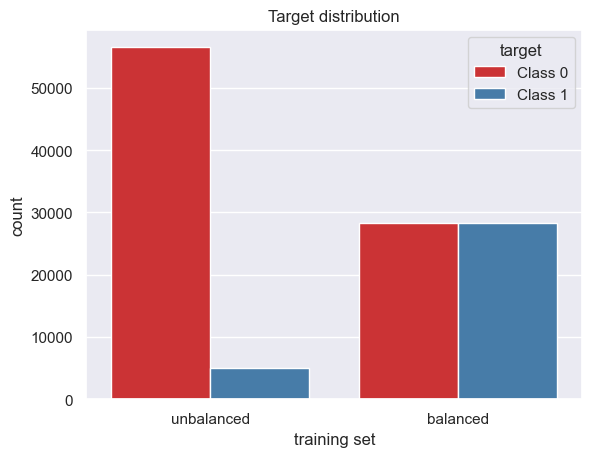

In [23]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()

## Elaboration du modele

* Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, avec une méthode au choix
* Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
* Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
* Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)
* En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy 

## Utilisation des donnees sans le SMOTE et laisser la gestion des valeurs manquantes par le modele directement.

In [24]:
@timeit
def echantillonage(df_X, df_y):
    X = df_X.copy()
    y = df_y.copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TRAIN_SIZE, random_state=RANDOM_STATE)
    
    return X_train, X_valid, y_train, y_valid

In [25]:
# Split dataset
x_train, x_test, y_train, y_test = echantillonage(features_X, target_y)

# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

Durée d'exécution de echantillonage: 3.330564022064209s


In [26]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 226132, 1.0: 19876})
Testing target statistics: Counter({0.0: 56554, 1.0: 4949})
Ratio is 1:11


### Creation d'un echantillon pour les divers tests d'algo sinon ca coute trop de temps/ressources

In [27]:
sample_X = data.drop(columns=TARGET).sample(n= 50000)
sample_y = data[TARGET][sample_X.index]

train_sample_set, val_sample_set, train_sample_labels, val_sample_labels = echantillonage(sample_X,sample_y)

Durée d'exécution de echantillonage: 0.18157219886779785s


In [28]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 605)

(10000, 605)

In [29]:
train_sample_set[TARGET]=train_sample_labels
val_sample_set[TARGET]=val_sample_labels

In [30]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 606)

(10000, 606)

In [31]:
train_sample_set = train_sample_set.reset_index()
val_sample_set = val_sample_set.reset_index()

In [32]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 607)

(10000, 607)

In [33]:
train_sample_set.drop(columns = ['index'], inplace=True)
val_sample_set.drop(columns = ['index'], inplace=True)

In [34]:
display(train_sample_set.shape)
display(val_sample_set.shape)

(40000, 606)

(10000, 606)

In [35]:
print('train shape :',x_train.shape)
print('validation shape :',x_test.shape)


print('train sample shape :',train_sample_set.shape)
print('validation sample shape :',val_sample_set.shape)

train shape : (246008, 605)
validation shape : (61503, 605)
train sample shape : (40000, 606)
validation sample shape : (10000, 606)


In [36]:
full_X = data.drop(columns=TARGET)
full_y = data[TARGET]

train_full_set, val_full_set, train_full_labels, val_full_labels = echantillonage(full_X, full_y)

Durée d'exécution de echantillonage: 1.376150369644165s


In [37]:
print('train full shape :',train_full_set.shape)
print('validation full shape :',val_full_set.shape)

train full shape : (246008, 605)
validation full shape : (61503, 605)


In [38]:
# ------------------ Paramètres métier ------------------
C_FN = 10.0   # coût d'un faux négatif (prêt accordé à tort)
C_FP = 1.0    # coût d'un faux positif (manque à gagner)

In [39]:
# Custom loss function based on business rule
def fonction_cout_metier(y_true, y_pred, seuil=0.5, c_fn=C_FN, c_fp=C_FP):
    '''
    Métrique métier tentant de minimiser le risque d'accord prêt pour la
    banque en pénalisant les faux négatifs.
    '''
    # liste des predictions selon un seuil de probabilité
    y_seuil = []
    for prob in y_pred:
        if prob >= seuil:
            y_seuil.append(1)
        else:
            y_seuil.append(0)
    
    # matrice de confusion
    mat_conf = confusion_matrix(y_true, y_pred)

    # nombre de true negatifs
    tn = mat_conf[0, 0]
    # nombre de false positifs
    fp = mat_conf[0, 1]
    # nombre de false negatifs
    fn = mat_conf[1, 0]
    # nombre de true positifs
    tp = mat_conf[1, 1]

    # cout total
    cout_t = tp*0 + tn*0 + fn*c_fn + fp*c_fp

    # cout max
    cout_max = (tp + fn)*c_fn + (tn + fp)*c_fp

    # cout min
    cout_min = (fp + tn)*0 + (tp + fn)*0

    # cout normalisé
    cout_n = (cout_t - cout_min) / (cout_max - cout_min)

    return cout_n

#### Je crée un score personnalisé avec la règle métier

In [40]:
# Create business score
business_score = make_scorer(fonction_cout_metier, greater_is_better=True)

## Fonction pour la classification

In [41]:
@timeit
def plot_roc_curve(classifiers, X, y, n_splits=5):

    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            clf.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = clf.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, thresholds = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            thresholds = auc(fpr, tpr)

            aucs.append(thresholds)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [42]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, x_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    # Draw roc curve
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # grille fine 0..1 + points probas
    grid = np.unique(np.clip(np.r_[np.linspace(0,1,401), y_pred_proba], 0, 1))
    costs = []
    for t in grid:
        y_pred = (y_pred_proba >= t).astype(int)
        cost_t = fonction_cout_metier(y_test, y_pred)  # doit renvoyer un coût (plus bas = mieux)
        costs.append(cost_t)

    best_idx = int(np.argmin(costs))
    best_thresh = float(grid[best_idx])
    business_score = float(costs[best_idx])

    print(f"[{model_name}] Best threshold = {best_thresh:.4f}")
    print(f"[{model_name}] Best business score = {business_score:.4f}")

    # business_score = []
    # for thresh in range(0, 100, 5):
    #     thresh = thresh / 1000
    #     y_pred_thresh = y_pred_proba >= thresh
    #     business_score_thresh = fonction_cout_metier(y_test, y_pred_thresh)
    #     business_score.append(business_score_thresh)
    # best_thresh = np.argmin(business_score) * 5 / 1000
    # print("Best threshold =", best_thresh)
    # business_score = min(business_score)
    # print("Best business score =", business_score)

    # Predict values
    y_pred = (y_pred_proba >= best_thresh).astype(int)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    return business_score, auc_score, clf_report, y_pred_proba, best_thresh, y_pred

## Baseline

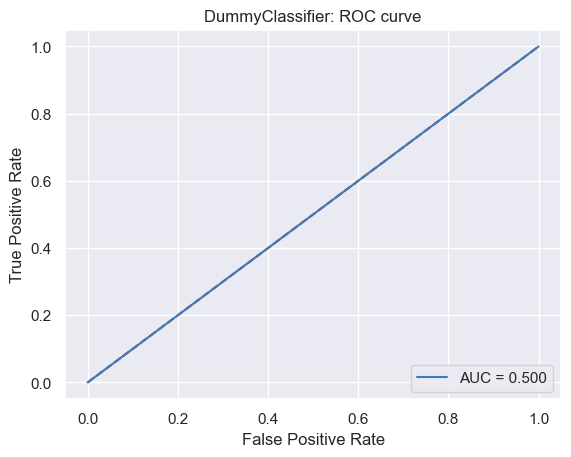

[DummyClassifier] Best threshold = 0.0025
[DummyClassifier] Best business score = 0.4667


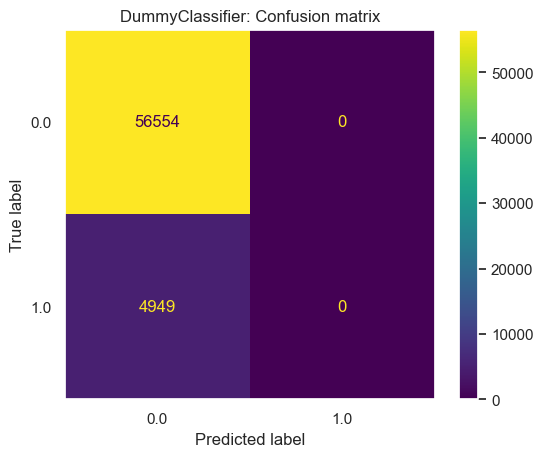

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

,precision,recall,f1-score,support
0.0,0.919532,1.000000,0.958080,56554.000000
1.0,0.000000,0.000000,0.000000,4949.000000
accuracy,0.919532,0.919532,0.919532,0.919532
macro avg,0.459766,0.500000,0.479040,61503.000000
weighted avg,0.845540,0.919532,0.880985,61503.000000


2025/09/19 16:07:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 16:08:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'ad0c9dc935f34677bdc4448b9f50dabd'

In [43]:
dc = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Fit model
dc.fit(train_full_set, train_full_labels)

# Compute results
dc_business_score, dc_auc, dc_report, dc_y_pred_proba, dc_best_thresh, dc_y_pred = compute_classification_results(dc, dc_name, val_full_set, val_full_labels)

# Save logs
log_mlflow(dc, 
           dc_name, 
           auc_score=dc_auc, 
           custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=accuracy_score(val_full_labels, dc_y_pred),
           y_pred_proba=dc_y_pred_proba,
           best_thresh=dc_best_thresh,
           y_pred=dc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

## Log Baseline to MLFlow

In [57]:
log_mlflow(dc, 
           dc_name, 
           auc_score=dc_auc, 
           custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=accuracy_score(val_full_labels, dc_y_pred),
           y_pred_proba=dc_y_pred_proba,
           best_thresh=dc_best_thresh,
           y_pred=dc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/09/19 23:37:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 23:37:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/107211667055519295/runs/04595f739c094903aff0fcc54bd375a8
🧪 View experiment at: http://localhost:5000/#/experiments/107211667055519295


'04595f739c094903aff0fcc54bd375a8'

## Regression Logistique

In [44]:
train_full_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246008 entries, 123473 to 121958
Columns: 605 entries, NAME_CONTRACT_TYPE to CC_NAME_CONTRACT_STATUS_nan_VAR
dtypes: bool(128), float64(436), int64(41)
memory usage: 927.2 MB


In [45]:
# Create logistic regression model
si = SimpleImputer(strategy='mean')
lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000)
lr_name = 'LogisticRegression'

pipe_lr = Pipeline([
    ('imputer', si),
    ('classifier', lr)
])

# Train model
pipe_lr.fit(train_full_set, train_full_labels)

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('imputer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,penalty,'l2'


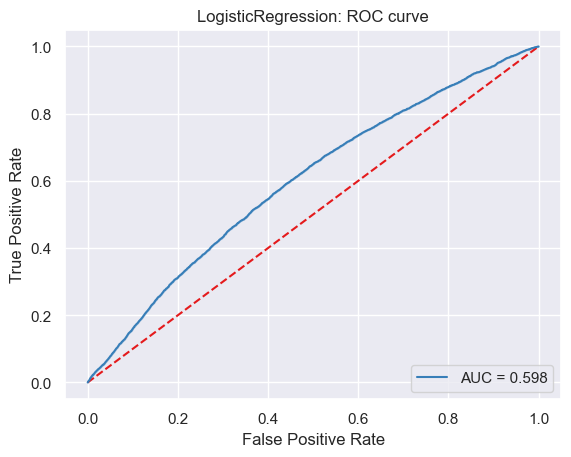

[LogisticRegression] Best threshold = 0.4932
[LogisticRegression] Best business score = 0.4222


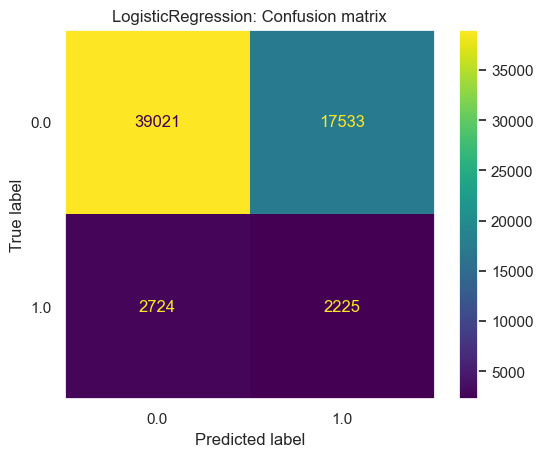

,precision,recall,f1-score,support
0.0,0.934747,0.689978,0.793925,56554.000000
1.0,0.112613,0.449586,0.180111,4949.000000
accuracy,0.670634,0.670634,0.670634,0.670634
macro avg,0.523680,0.569782,0.487018,61503.000000
weighted avg,0.868592,0.670634,0.744533,61503.000000


2025/09/19 17:17:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 17:17:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'93e95cdc172f486ca03022dae184e1c5'

In [46]:
# Compute results
lr_business_score, lr_auc, lr_report, lr_y_pred_proba, lr_best_thresh, lr_y_pred = compute_classification_results(pipe_lr, lr_name, val_full_set, val_full_labels)

# Save logs
log_mlflow(pipe_lr, lr_name, 
           auc_score=lr_auc, 
           custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           y_pred_proba=lr_y_pred_proba,
           best_thresh=lr_best_thresh,
           y_pred=lr_y_pred,
           train_class_0=Counter(train_full_labels)[0], 
           train_class_1=Counter(train_full_labels)[1])

## Log Regression Logistique to MLFlow

In [58]:
log_mlflow(pipe_lr, lr_name, 
           auc_score=lr_auc, 
           custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           y_pred_proba=lr_y_pred_proba,
           best_thresh=lr_best_thresh,
           y_pred=lr_y_pred,
           train_class_0=Counter(train_full_labels)[0], 
           train_class_1=Counter(train_full_labels)[1])

2025/09/19 23:38:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 23:38:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/107211667055519295/runs/a810dec007c4421e9bac9475c7f8159b
🧪 View experiment at: http://localhost:5000/#/experiments/107211667055519295


'a810dec007c4421e9bac9475c7f8159b'

In [47]:
def scale_pos_weight(y):
    # ratio négatifs / positifs pour LGBM & XGB (utile en données déséquilibrées)
    pos = (y == 1).sum()
    neg = (y == 0).sum()
    return max(1.0, neg / max(1, pos))

## LGBM

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61726
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 597
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


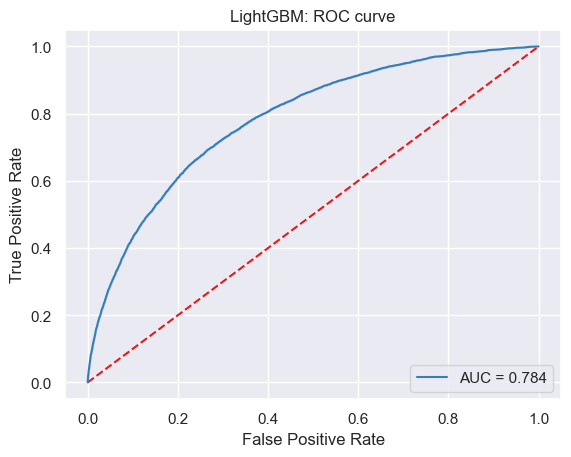

[LightGBM] Best threshold = 0.5400
[LightGBM] Best business score = 0.2850


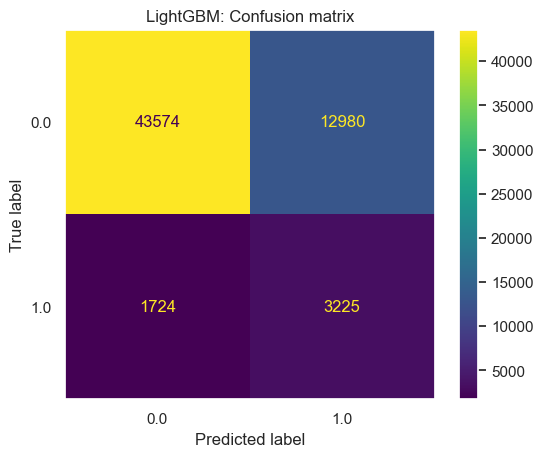

,precision,recall,f1-score,support
0.0,0.961941,0.770485,0.855634,56554.000000
1.0,0.199013,0.651647,0.304907,4949.000000
accuracy,0.760922,0.760922,0.760922,0.760922
macro avg,0.580477,0.711066,0.580270,61503.000000
weighted avg,0.900550,0.760922,0.811318,61503.000000


2025/09/19 18:26:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 18:26:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'621a9fdc313c4375b9626926f02df8da'

In [48]:
# Create light gradient boosting model classifier
lgbm = LGBMClassifier(scale_pos_weight=scale_pos_weight(train_full_labels), random_state=RANDOM_STATE)
lgbm_name = 'LightGBM'

# Train model
lgbm.fit(train_full_set, train_full_labels)

# Compute results
lgbm_business_score, lgbm_auc, lgbm_report, lgbm_y_pred_proba, lgbm_best_thresh, lgbm_y_pred = compute_classification_results(lgbm, lgbm_name, val_full_set, val_full_labels)

# Save logs
lgbm_params = lgbm.get_params()
log_mlflow(lgbm, 
           lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'],
           y_pred_proba=lgbm_y_pred_proba,
           best_thresh=lgbm_best_thresh,
           y_pred=lgbm_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

## Log LGBM to MLFlow

In [59]:
log_mlflow(lgbm, 
           lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'],
           y_pred_proba=lgbm_y_pred_proba,
           best_thresh=lgbm_best_thresh,
           y_pred=lgbm_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/09/19 23:39:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 23:39:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/107211667055519295/runs/aac61b21dd7a4c148d302bfe4d5f6717
🧪 View experiment at: http://localhost:5000/#/experiments/107211667055519295


'aac61b21dd7a4c148d302bfe4d5f6717'

## XGBoost

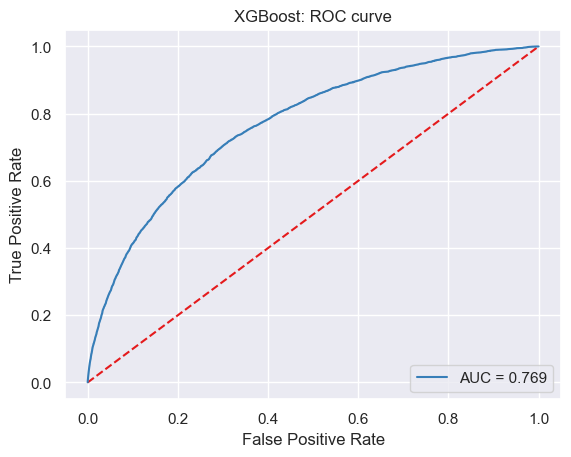

[XGBoost] Best threshold = 0.4378
[XGBoost] Best business score = 0.2973


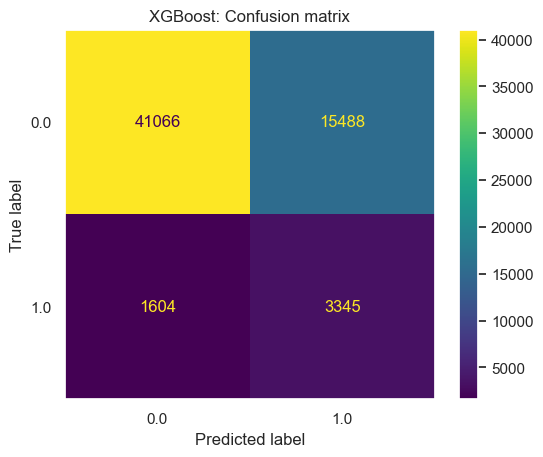

,precision,recall,f1-score,support
0.0,0.962409,0.726138,0.827743,56554.000000
1.0,0.177614,0.675894,0.281305,4949.000000
accuracy,0.722095,0.722095,0.722095,0.722095
macro avg,0.570011,0.701016,0.554524,61503.000000
weighted avg,0.899259,0.722095,0.783773,61503.000000


2025/09/19 19:46:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 19:46:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'a279dabc16e34f0d91b5035fc934a85a'

In [49]:
# Create XGBoost classifier
xgbc = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight(train_full_labels), random_state=RANDOM_STATE)
xgbc_name = 'XGBoost'

# Train model
xgbc.fit(train_full_set, train_full_labels)

# Compute results
xgbc_business_score, xgbc_auc, xgbc_report, xgbc_y_pred_proba, xgbc_best_thresh, xgbc_y_pred = compute_classification_results(xgbc, xgbc_name, val_full_set, val_full_labels)

# Save logs
xgbc_params = xgbc.get_params()
log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'],
           y_pred_proba=xgbc_y_pred_proba,
           best_thresh=xgbc_best_thresh,
           y_pred=xgbc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

## Log XGBoost to MLFlow 

In [60]:
log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'],
           y_pred_proba=xgbc_y_pred_proba,
           best_thresh=xgbc_best_thresh,
           y_pred=xgbc_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/09/19 23:39:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 23:39:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/107211667055519295/runs/755df5eed7df4875b1471fc488c9b891
🧪 View experiment at: http://localhost:5000/#/experiments/107211667055519295


'755df5eed7df4875b1471fc488c9b891'

### Creer un tableau de comparaison

In [50]:
res_df = pd.DataFrame({
    'Model':['Dummy', 'LogisticRegression', 'LightGBM', 'XGBoost'],
    'Business score': [dc_business_score, lr_business_score, lgbm_business_score, xgbc_business_score],
    'Accuracy': [dc_report.loc['accuracy', 'precision'],
                 lr_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision'],
                 xgbc_report.loc['accuracy', 'precision']],
    'Precision': [dc_report.loc['macro avg', 'precision'],
                 lr_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision'],
                 xgbc_report.loc['macro avg', 'precision']],
    'Recall': [dc_report.loc['macro avg', 'recall'],
               lr_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall'],
               xgbc_report.loc['macro avg', 'recall']],
    'F-1 score': [dc_report.loc['macro avg', 'f1-score'],
                  lr_report.loc['macro avg', 'f1-score'],
                  lgbm_report.loc['macro avg', 'f1-score'],
                  xgbc_report.loc['macro avg', 'f1-score']],
    'AUC score': [dc_auc, lr_auc, lgbm_auc, xgbc_auc],
    'Best threshold': [dc_best_thresh, lr_best_thresh, lgbm_best_thresh, xgbc_best_thresh],
    'Predicted probabilities': [dc_y_pred_proba, lr_y_pred_proba, lgbm_y_pred_proba, xgbc_y_pred_proba],
    'Predictions': [dc_y_pred, lr_y_pred, lgbm_y_pred, xgbc_y_pred]
})

display(res_df)

,Model,Business score,Accuracy,Precision,Recall,F-1 score,AUC score,Best threshold,Predicted probabilities,Predictions
0,Dummy,0.466693,0.919532,0.459766,0.500000,0.479040,0.500000,0.002500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LogisticRegression,0.422212,0.670634,0.523680,0.569782,0.487018,0.597879,0.493244,"[0.49205818719318983, 0.3543871503954327, 0.51...","[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, ..."
2,LightGBM,0.284976,0.760922,0.580477,0.711066,0.580270,0.783834,0.539974,"[0.6535464655433384, 0.3616678688501471, 0.689...","[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, ..."
3,XGBoost,0.297311,0.722095,0.570011,0.701016,0.554524,0.768818,0.437836,"[0.72991514, 0.2737059, 0.64394, 0.097455874, ...","[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, ..."


#### Notre priorite est la minimisation du cout metier (busniess score) donc XGBoost est le meilleur modele et le meilleur F1.
#### En parallele LGBM est tres proche, meilleur AUC (capacite de classement global), et une precision plus forte (mmoins de FP)
#### Initialement j'opterais pour XGBoost, mais LGBM sera peut etre plus rapide. Il faudra donc modifier certains parametres.

In [51]:
import gc

## LGBM Hyperparameters Tuning

{'colsample_bytree': 0.8768352823634579, 'learning_rate': 0.0665977312596097, 'max_depth': 8, 'min_child_samples': 100, 'n_estimators': 1400, 'num_leaves': 48, 'reg_alpha': 0.05813857963019929, 'reg_lambda': 0.1235213651783935, 'subsample': 0.8401524105974222}
[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61693                   
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 586
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080795 -> initscore=-2.431590
[LightGBM] [Info] Start training from score -2.431590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

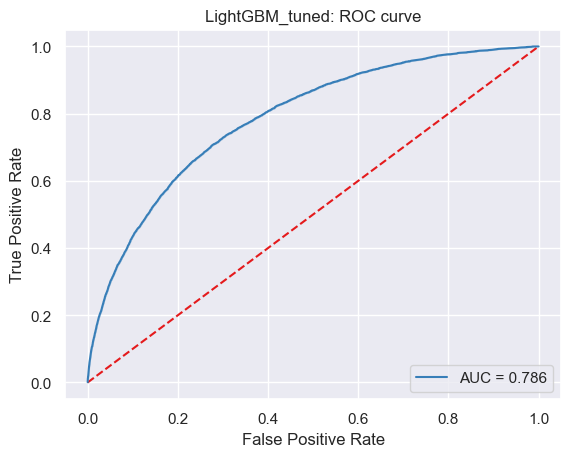

[LightGBM_tuned] Best threshold = 0.5048
[LightGBM_tuned] Best business score = 0.2837


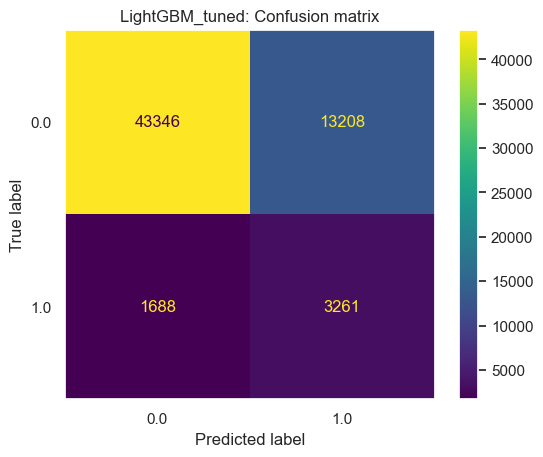

,precision,recall,f1-score,support
0.0,0.962517,0.766453,0.853369,56554.0000
1.0,0.198008,0.658921,0.304510,4949.0000
accuracy,0.757800,0.757800,0.757800,0.7578
macro avg,0.580263,0.712687,0.578939,61503.0000
weighted avg,0.900999,0.757800,0.809203,61503.0000


2025/09/19 21:29:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 21:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'737741b16a674175b79f38c70ab6bc2d'

In [52]:
# Create LightGBM classifier for tuning
lgbmt = LGBMClassifier(scale_pos_weight=scale_pos_weight(train_full_labels), random_state=RANDOM_STATE)
lgbmt_name = 'LightGBM_tuned'

# Possible values of hyperparameters
lgbmt_space = {
    "n_estimators":      scope.int(hp.quniform("n_estimators", 400, 1500, 100)),
    "max_depth":         scope.int(hp.quniform("max_depth", 3, 12, 1)),
    "num_leaves":        scope.int(hp.quniform("num_leaves", 16, 128, 4)),
    "learning_rate":     hp.loguniform("learning_rate", np.log(0.005), np.log(0.2)),
    "subsample":         hp.uniform("subsample", 0.6, 1.0),        # bagging_fraction
    "colsample_bytree":  hp.uniform("colsample_bytree", 0.6, 1.0), # feature_fraction
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 200, 10)),
    "reg_alpha":         hp.loguniform("reg_alpha", np.log(1e-3), np.log(10.0)),
    "reg_lambda":        hp.loguniform("reg_lambda", np.log(1e-3), np.log(10.0))
}

# define objective function
def lgbmt_tuning(params):
    # Cast integer parameters to int
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])

    print(params)

    lgbmt.set_params(**params)
    score = cross_val_score(lgbmt, train_full_set, train_full_labels, scoring=business_score).mean()
    return {"loss": -score, "status": STATUS_OK, "model":lgbmt}

# Initialize trials object
lgbmt_trials = Trials()

# Find best model
lgbmt_best = fmin(fn=lgbmt_tuning, 
                space=lgbmt_space, 
                algo=tpe.suggest, max_evals=5, trials=lgbmt_trials)
lgbmt_best_model = trials_best_model(lgbmt_trials)
print(lgbmt_best_model)

# Train model
lgbmt_best_model.fit(train_full_set, train_full_labels)

# Compute results
lgbmt_business_score, lgbmt_auc, lgbmt_report, lgbmt_y_pred_proba, lgbmt_best_thresh, lgbmt_y_pred = compute_classification_results(lgbmt_best_model, lgbmt_name, val_full_set, val_full_labels)

# Save logs
lgbmt_params = lgbmt.get_params()
log_mlflow(lgbmt_best_model, lgbmt_name,
           custom_score=lgbmt_business_score,
           auc_score=lgbmt_auc,
           f1_score=lgbmt_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbmt_report.loc['accuracy', 'precision'],
           n_estimator=lgbmt_params['n_estimators'],
           max_depth=lgbmt_params['max_depth'],
           y_pred_proba=lgbmt_y_pred_proba,
           best_thresh=lgbmt_best_thresh,
           y_pred=lgbmt_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

## Log LGBM tunned to MLFlow

In [61]:
log_mlflow(lgbmt_best_model, lgbmt_name,
           custom_score=lgbmt_business_score,
           auc_score=lgbmt_auc,
           f1_score=lgbmt_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbmt_report.loc['accuracy', 'precision'],
           n_estimator=lgbmt_params['n_estimators'],
           max_depth=lgbmt_params['max_depth'],
           y_pred_proba=lgbmt_y_pred_proba,
           best_thresh=lgbmt_best_thresh,
           y_pred=lgbmt_y_pred,
           train_class_0=Counter(train_full_labels)[0],
           train_class_1=Counter(train_full_labels)[1])

2025/09/19 23:40:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/19 23:40:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM_tuned at: http://localhost:5000/#/experiments/107211667055519295/runs/16fd46d4e4824cd1af0c19deadd84d4a
🧪 View experiment at: http://localhost:5000/#/experiments/107211667055519295


'16fd46d4e4824cd1af0c19deadd84d4a'

## Features importance

### Methode

In [53]:
#%pip install shap --upgrade

## Deploiement API